<a href="https://colab.research.google.com/github/GongBakDong/DAP__/blob/main/DAP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

제시했던 dataset 중 가장 높은 실력을 가지고 있는 Challanger 집단의 dataset을 선택하여 업로드해옴.


In [2]:
from google.colab import files
myfile = files.upload()

Saving LOL_RankGames.csv to LOL_RankGames.csv


blue team, red team 각 16개의 열, 게임진행시간과 gameid 까지 34개의 열을 가지고 있음.

In [3]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

dataframe head 확인

In [4]:
df = pd.read_csv('LOL_RankGames.csv')

df.head()

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueDragonKills,blueBaronKills,blueTowerKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueTotalGold,blueTotalLevel,blueAvgLevel,redWins,redFirstBlood,redFirstTower,redFirstBaron,redFirstDragon,redDragonKills,redBaronKills,redTowerKills,redWardPlaced,redWardkills,redKills,redDeath,redAssist,redTotalGold,redTotalLevel,redAvgLevel
0,4247263043,1323,0,1,0,0,0,0,0,0,38,13,15,31,22,37001,56,11.2,1,0,1,0,1,3,0,9,50,17,31,15,68,49832,64,12.8
1,4247155821,1317,1,0,0,0,1,2,0,4,57,18,19,8,31,41072,63,12.6,0,1,1,0,0,0,0,2,46,18,8,19,8,37136,59,11.8
2,4243963257,932,0,0,0,0,0,0,0,0,28,7,5,20,8,22929,42,8.4,1,1,1,0,1,2,0,5,40,9,20,5,20,35364,50,10.0
3,4241678498,2098,0,0,0,1,1,1,1,2,129,39,26,36,45,63447,80,16.0,1,1,1,0,0,3,1,6,96,56,36,26,72,70528,84,16.8
4,4241538868,2344,1,1,1,1,1,2,2,11,114,35,27,40,47,74955,83,16.6,0,0,0,0,0,3,1,6,100,43,40,27,83,74596,85,17.0


알아볼 통계
1. 19년 자료임으로, 아직 버그로 인해 blue팀의 대포 미니언의 공격 사거리가 20 높았을때임. 고로 이 점으로 인해 양 팀간 FirstTower의 차이가 존재하는지 확인하고 이게 승률이 큰 영향을 미쳤는지 확인하고, 추가적으로 보편적으로 높은 킬 = 승리 라는 공식이라고 생각되는 LOL에서 실제로 높은 상관계수를 띄고있는지 확인해봄.
2. LOL에서 높은 점수대에 도달할수록, 시야를 밝혀주는 '와드'라는 아이템의 중요도가 높아짐. 각 팀의 승리와 패배 시에, 상대방이 설치한 와드의 평균을 비교해봄.
3. 머신러닝을 통해 승패 예측 모델을 제작



**1-1번**. red팀과 blue팀의 대응되는 columns은 모두 50:50 이게 게임을 설계하는 것이 기본이고, 2021년 통계 기준 모든 columns은 50:50임.

블루 팀이 먼저 첫 번째 포탑을 부순 경우
 1    14141
0    12763
Name: blueFirstTower, dtype: int64


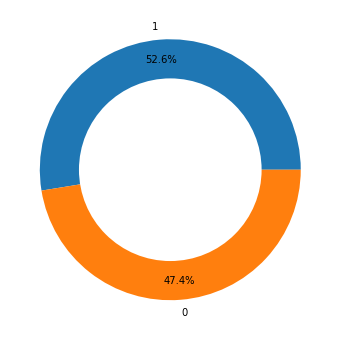

In [5]:
BlueFirstTower = df['blueFirstTower'].value_counts()
print('블루 팀이 먼저 첫 번째 포탑을 부순 경우\n', BlueFirstTower)
fig, ax = plt.subplots(figsize=(6,6))

labels = BlueFirstTower.index
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

ax.pie(BlueFirstTower, labels=labels, startangle=0,  autopct='%.1f%%', counterclock=True, pctdistance=0.85)

#draw white circle in the middle
centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.set(aspect='equal')


plt.show()



허나 FirstTowerKill이 blue 팀의 대포 미니언 사거리 버그로 인해 2021년 현재와 차이가 있는 것을 알 수 있음. 그러면 이제 이 결과가 승률에 영향을 주었는가? 를 확인

블루 팀 승리 수  1    13454
0    13450
Name: blueWins, dtype: int64


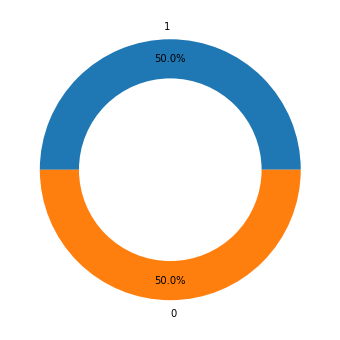

In [6]:
WinCount = df['blueWins'].value_counts()
print('블루 팀 승리 수 ' , WinCount)
fig, ax = plt.subplots(figsize=(6,6))

labels = WinCount.index
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

ax.pie(WinCount, labels=labels, startangle=0,  autopct='%.1f%%', counterclock=True, pctdistance=0.85)

#draw white circle in the middle
centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.set(aspect='equal')


plt.show()

In [7]:
selectedDataFrame = df[['blueWins','blueFirstTower']]
selectedDataFrame.corr(method='pearson')


,blueWins,blueFirstTower
blueWins,1.000000,0.449065
blueFirstTower,0.449065,1.000000


**1-1번 마무리** : 대포 미니언 사거리 20의 차이는, 작은 차이 같지만 실제로 첫 번째 포탑을 부수는데에 어느정도 영향을 주었고, 피어슨 상관계수로 보아도 승리와 첫번째 포탑을 부수는 건 뚜렷한 양의 선형 관계를 띄고있다. 허나 전체 승률으로 봤을때는 50:50과 근접한 결과를 보인다.

--------------------------------------------------
**1-2번. Kill 수와 승리의 상관 관계**

롤이라는 게임은 기본적으로 상대를 죽이고, 포탑을 부수거나 킬 골드로 성장을 하는 매커니즘이기 때문에 당연하게 kill 수 와 승리는 높은 연관이 있다는 것이 정설이다.

In [8]:
## Complte the code
selectedDataFrame2 = df[['blueKills','blueWins']]
selectedDataFrame2.corr(method='pearson')
 

,blueKills,blueWins
blueKills,1.000000,0.453521
blueWins,0.453521,1.000000


In [9]:
selectedDataFrame2 = df[['redKills','blueWins']]
selectedDataFrame2.corr(method='pearson')

,redKills,blueWins
redKills,1.000000,-0.441799
blueWins,-0.441799,1.000000


**1-2 결과)** blue팀의 킬 수와 blue승률은 양의 상관관계를, 
red팀의 킬 수와 blue팀의 승률은 음의 상관관계를 띄지만 서로 모두 강하게 상관관계가 나타나는 것이 아니고, 적절한 선형관계를 띄는 것으로 보아 
킬과 승리는 상관관계이지만, 여러 오브젝트나 순간의 실수와 같은 수많은 승리 요소가 있기 때문에 그렇게 까지 강한 상관관계까지는 띄지 않음을 알 수 있다.

------------------------------------------------------------------

# **2번** 높은 티어일수록 와드의 설치 수가 승리에 큰 영향을 준다는 것이 정설이다. 그렇기 때문에 챌린저 집단의 블루 팀과 레드 팀 각각 승리 시 상대방의 와드 갯수의 평균을 확인한다.

1- 블루팀이 승리했을시 레드 팀의 평균 설치 와드 갯수

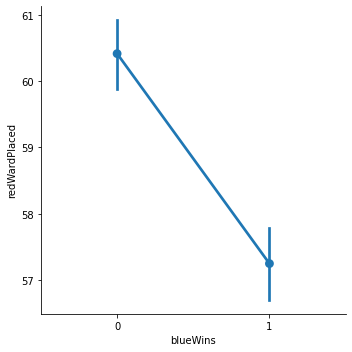

In [10]:
import warnings
warnings.filterwarnings('ignore')

def first_valid_visualize(df,target,variable):
    sns.factorplot(target, variable,data=df)
    plt.show()
first_valid_visualize(df,'blueWins','redWardPlaced')
plt.show()

2- 레드팀이 승리했을시 블루 팀의 평균 와드 설치 갯수

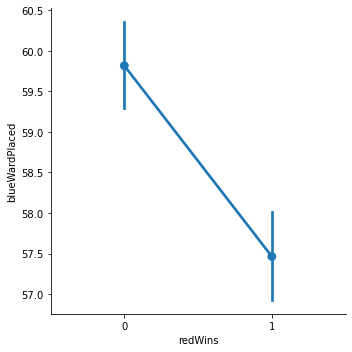

In [11]:
first_valid_visualize(df,'redWins','blueWardPlaced')
plt.show()

3- 블루 팀이 승리했을시 블루 팀의 평균 와드 설치 갯수

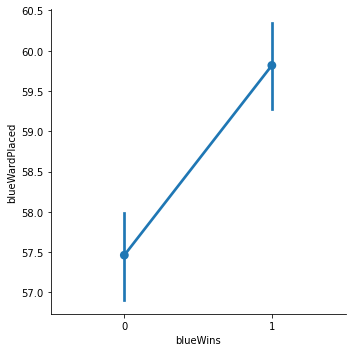

In [12]:
first_valid_visualize(df,'blueWins','blueWardPlaced')
plt.show()

4- 레드 팀이 승리했을시 레드 팀 평균 와드 설치 갯수

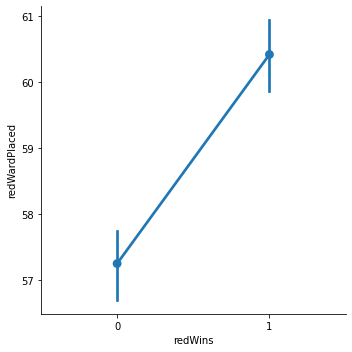

In [13]:
first_valid_visualize(df,'redWins','redWardPlaced')
plt.show()

**2번 결과** 예상대로 각 팀이 승리 시, 상대 편의 평균 와드 갯수가 적은 것을 확인할 수 있다.

----------------------------------------------------------

# **3번.** 승패예측 머신

먼저, 보다 쾌적한 머신러닝을 위해 red팀 columns과 게임 진행시간을 drop한 df을 생성하고, target데이터를 제외한 열을 가진 df인 df_one2를 생성함

In [ ]:
df_one = df.drop(['gameDuraton','redWins','redFirstBlood','redFirstTower','redFirstBaron','redFirstDragon','redDragonKills','redBaronKills','redTowerKills','redWardPlaced','redWardkills','redKills','redDeath','redAssist','redTotalGold','redTotalLevel','redAvgLevel'], axis=1)
df_one.columns
df_one = df_one.dropna(axis=0)
df_one2 = df_one[list(df_one.columns)[2:]]


라벨링 진행, 종속 변수도 라벨링

In [ ]:
from sklearn.preprocessing import LabelEncoder
for i in range(0,6):
    le = LabelEncoder()
    y = list(df_one2.iloc[:,i])
    
    le.fit(y)
    y2 = le.transform(y) 
    
    df_one2.iloc[:,i] = y2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
dict_winner2 = {1 : 0, 0 : 1}
df_one['blueWins'].map(dict_winner2).tolist()

[1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,


train 데이터와 test 데이터를 0.75 : 0.25비율로 나눔

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_one2, np.array(df_one['blueWins'].map(dict_winner2).tolist()), test_size=0.25, stratify=np.array(df_one['blueWins'].map(dict_winner2).tolist()), random_state=123456)

Random forest 방식으로 학습 진행

*oob_score = out of bag score(예측 정확도 추정치)*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train) 

from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Out-of-bag score estimate: 0.969
Mean accuracy score: 0.971


높은 테스트 정확도를 보이는 모델 생성 완료

**3-2번.** 추가적인 변수 중요도 확인

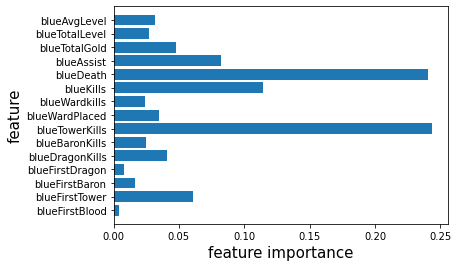

In [ ]:
n_feature = df_one2.shape[1]

index = np.arange(n_feature)
feature_names = df_one2.columns.tolist()
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest.fit(X_train, y_train)

plt.barh(index, forest.feature_importances_, align='center')
plt.yticks(index, feature_names)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)

plt.show()

**3-2 결과**. RandomForest 모델로 확인 했을때, Death와 Towerkill을 가장 높은 점수를 부여하고, 그뒤로는 킬이나 어시스트 등이 따라옴.

-------------------------------------------------------------------

**결론** :19년도 당시 존재했던 블루 팀 대포 사거리 버그는, firsttower kill이 블루팀이 확연하게 더 많이 해냈음을 알 수 있고, Firsttowerkill은 승리와 어느정도 상관관계를 띄고 있다. 허나 승리로 향하는 수 많은 변수를 모두 따져보았을때, 그건 blueDeath나 총 towerkill, kill과 같은 다른 높은 영향을 가진 요소가 많기에 blue team과 red team의 승률은 50:50이 유지 되고 있었다. 그리고, 높은 점수대의 게임을 data로 잡은만큼 실제로 한 팀이 승리했을때와 패배했을때의 ward 총 갯수는 확연한 차이를 보인다.